In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

# hyperparameters
N_e = 100
N_i = N_e
N = N_e + N_i
D = 30
sparsity = 0.25
U = 200
T = 100
N_weights = int (N * N * sparsity)
max_iter=50

zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2)) for i in list(np.arange(-1.5,0.5,0.25))]

In [2]:
# simulation of interest
K = 5
simulation = 49
j = 0 # normal
data = np.load(f'models/N={N}_K={K}_parameters_simulation_{simulation}_J_possibility_{j}.npz', allow_pickle=True)
J = data['J']
RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)

In [3]:
# eigenvalues = np.array([0.9, - 0.1 + 0.5j, - 0.1 - 0.5j])
trueA = data['trueA']
eigenvalues = np.linalg.eig(trueA)

4.238967629746156


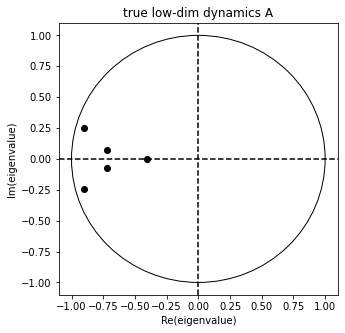

In [4]:
# eigenvalues = np.array([0.9, - 0.1 + 0.5j, - 0.1 - 0.5j])[:K]
# trueA = generate_dynamics_A(eigenvalues) # checked that A has above eigenvalues
# # trueA = all_param_true['trueA']

# trueA = np.ones((1,1)) * 0.9
# trueA = np.zeros((K,K))
# theta = np.pi/6
# trueA[0,0] = np.cos(theta)
# trueA[0,1] = - np.sin(theta)
# trueA[1,0] = np.sin(theta)
# trueA[1,1] = np.cos(theta)
# trueA = trueA * 0.95

eigenvalues = np.linalg.eigvals(trueA)
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('true low-dim dynamics A')
plot_eigenvalues(axes, eigenvalues)

print(np.trace(trueA.T @ trueA))
norm_A = np.trace(trueA.T @ trueA)



In [5]:
# creating eigenvalues sets for cluster fitting

# a = np.random.rand(1)[0]
# b = np.random.rand(1)[0]
# eigenvalues_odd = np.array([0.9, - 0.2 + 0.6j, - 0.2 - 0.6j, a + b*1j, a - b*1j])
# np.save('eigenvalues_K_odd_leq_5', eigenvalues_odd)

# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('true low-dim dynamics A')
# plot_eigenvalues(axes, eigenvalues_odd)

# eigenvalues_even = []
# for i in range(5):
#     x = 2 * (np.random.rand(1)[0] - 1/2)
#     y = 2 * (np.random.rand(1)[0] - 1/2)
#     eigenvalues_even.append(x + y * 1j)
#     eigenvalues_even.append(x - y * 1j)

# print(len(eigenvalues_even))
# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('true low-dim dynamics A')
# plot_eigenvalues(axes, np.array(eigenvalues_even)[:10])
# np.save('eigenvalues_K_even_leq_10', eigenvalues_even)


        

In [6]:
# # Weight initialization (step 0) - Hannequin et al 2012
# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# w0 = RNN.generate_stable_weights(R=0.85) 
# W0 = RNN.build_full_weight_matrix(w0)

# eig = np.linalg.eigvals(W0) 
# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('W initialization (step 0)')
# plot_eigenvalues(axes, eig)


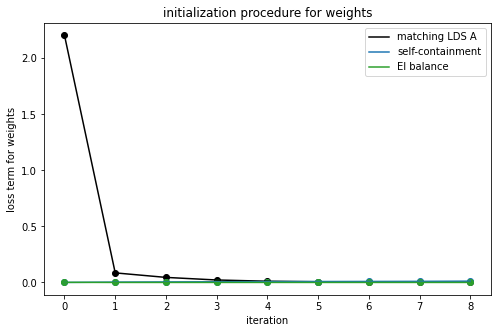

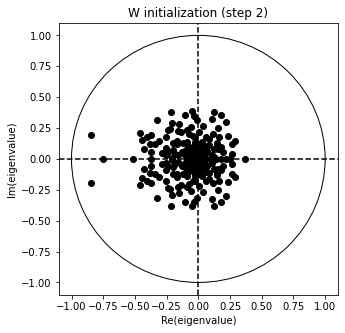

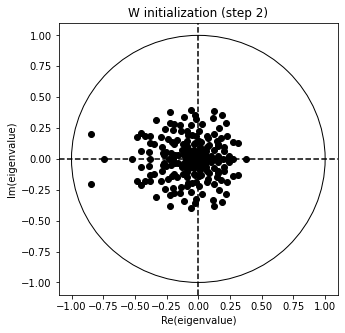

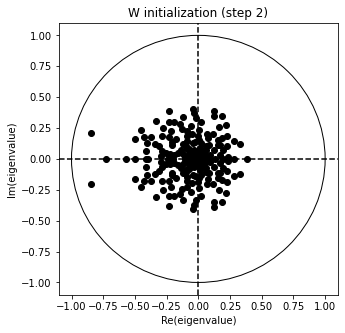

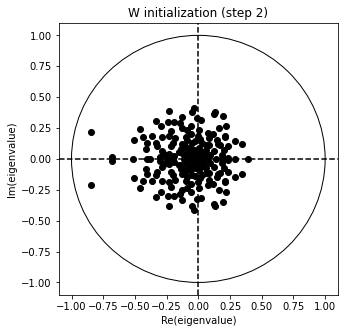

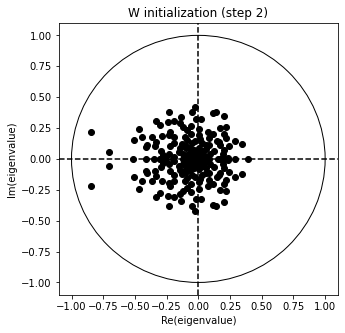

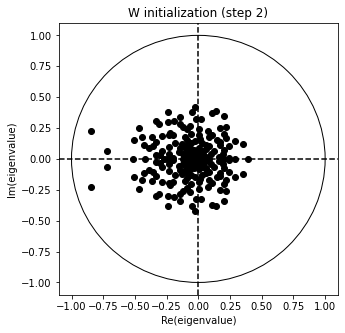

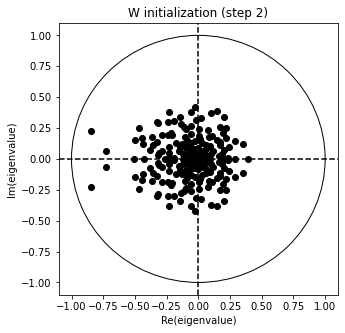

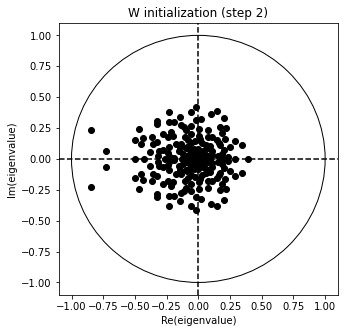

In [7]:
import math
# # Weight initialization - from true target LDS A
# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# # gamma = 0.001 works well for N<=150
# # gamma = 0.005 = 1/N for N=200 => instability
# # zeta_alpha_beta_gamma_list = [(10**i,1,1,1/N) for i in list(np.arange(-3,0.5,0.5))] #[10 ** i for i in list(np.arange(-3,1,0.5))]
# zeta_alpha_beta_gamma_list = [(10**i,1,1,0) for i in list(np.arange(-1,0.5,0.5))] #[10 ** i for i in list(np.arange(-3,1,0.5))]
# # try gamma scheme from high to low
# # try zeta scheme from N/norm_A
# initW0, initW, loss_W, w_all = RNN.generate_or_initialize_weights_from_dynamics_LDS(A_target=trueA, R=0.85, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
# init_w = RNN.get_nonzero_weight_vector(initW)
# initA = build_dynamics_matrix_A(initW, J)
# # np.save('loss_W', loss_W)
# # np.save('init_w', init_w)

initW0 = data['initW0']
initW = data['initW']
loss_W = data['loss_W']
w_all = data['w_all']


fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black', label='matching LDS A')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('initialization procedure for weights')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')

for ind in range(len(zeta_alpha_beta_gamma_list)):
    Winit = RNN.build_full_weight_matrix(w_all[ind])
    eig = np.linalg.eigvals(Winit) 
    fig, axes = plt.subplots(figsize=(5,5))
    axes.set_title('W initialization (step 2)')
    plot_eigenvalues(axes, eig)

In [8]:
# # np.savez(f'N={N}_K={K}_initialization_weights', initW0=initW0, initW =initW, loss_W = loss_W, w_all = w_all)
# a = np.load(f'N={N}_K={K}_initialization_weights.npz')
# initW0 = a['initW0']
# initW = a['initW']
# loss_W = a['loss_W']
# w_all = a['w_all']
# init_w = RNN.get_nonzero_weight_vector(initW)
# initA = build_dynamics_matrix_A(initW, J)

# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# zeta_alpha_beta_gamma_list = [(10**i,1,1,0.001) for i in list(np.arange(-3,0.5,0.5))]

In [9]:
# Jpinv_aux = J @ initW @ (np.identity((N)) - np.linalg.pinv(J) @ J)
# print(0.5  * np.trace(Jpinv_aux @ Jpinv_aux.T))

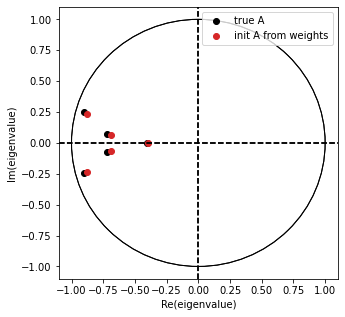

In [10]:
fig, axes = plt.subplots(figsize=(5,5))
eig = np.linalg.eigvals(trueA) 
plot_eigenvalues(axes, eig, color='black', label='true A')
initA = build_dynamics_matrix_A(initW, J)
eig = np.linalg.eigvals(initA) 
plot_eigenvalues(axes, eig, color='tab:red', label='init A from weights')
axes.legend()
plt.show()

In [11]:
# # np.savez(f'N={N}_K={K}_true_parameters', J=J, trueA=trueA, true_b=true_b, true_s=true_s, true_mu0=true_mu0, true_Q0=true_Q0, true_C_=true_C_, true_d=true_d, true_R=true_R)
# a = np.load(f'N={N}_K={K}_true_parameters.npz')
# print(a['J'].shape)

In [12]:
max_iter = 50
ecll = data['ecll']
ll = data['ll']
lossW = data['lossW']
fitW = data['fitW']
b = data['b']
s = data['s']
mu0 = data['mu0']
Q0 = data['Q0']
C_ = data['C_']
d = data['d']
R = data['R']
true_b = data['true_b']
true_s = data['true_s']
true_mu0 = data['true_mu0']
true_Q0 = data['true_Q0']
true_C_ = data['true_C_']
true_d = data['true_d']
true_R = data['true_R']
true_x = data['true_x']
true_y = data['true_y']


In [13]:
# # save fitted parameters
# np.savez(f'N={N}_K={K}_fitting_EM', lossW=lossW, w=w, b=b, s=s, mu0=mu0, Q0=Q0, C_=C_, d=d, R=R)
# a = np.load(f'N={N}_K={K}_initialization_weights.npz')
# print(a['initW0'].shape)

In [15]:
# fit starting from true parameters 
init_w = RNN.get_nonzero_weight_vector(initW)
max_iter=25
ecll, ll, loss_W, w, b, s, mu0, Q0, C_, d, R, C_all, d_all, R_all = RNN.fit_EM(true_y, init_w, true_b.item(), true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=10, beta=10, max_iter=max_iter)

Text(0.5, 0, '# passed iterations')

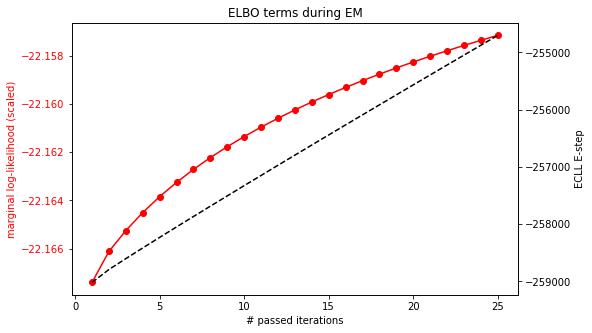

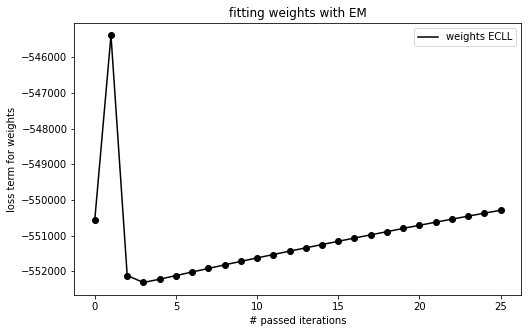

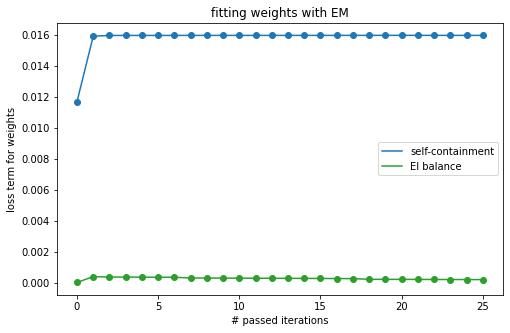

In [16]:
# iteration 0 = initialization, iteration 1 = param after one iteration
fig, axes = plt.subplots(figsize=(8,5))
ax2 = axes.twinx()
axes.plot(range(1,max_iter+1), (ll.sum(axis=1)/(U*T))[1:], '-o', color='red')
axes.tick_params(axis='y', labelcolor='red')
axes.set_ylabel('marginal log-likelihood (scaled)', color='red')
ax2.plot(range(1,max_iter+1), ecll[1:], color='black', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('ECLL E-step')
axes.set_title('ELBO terms during EM')
axes.set_xlabel('# passed iterations')

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(max_iter+1), loss_W[:,0], color='black', label='weights ECLL')
axes.scatter(range(max_iter+1), loss_W[:,0], color='black')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('# passed iterations')

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(max_iter+1), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(max_iter+1), loss_W[:,1], color='tab:blue')
axes.plot(range(max_iter+1), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(max_iter+1), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('# passed iterations')


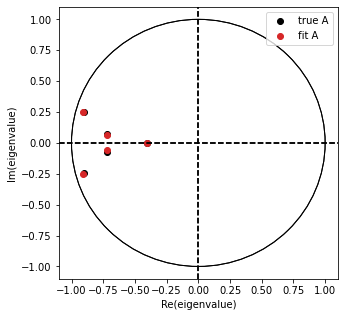

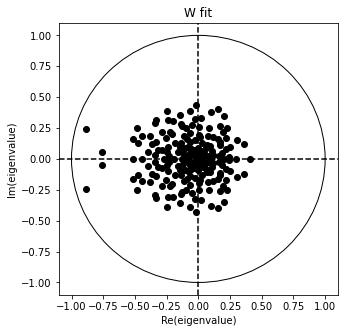

In [17]:
# recovered eigenspectrum from weights
fig, axes = plt.subplots(figsize=(5,5))
fitA = build_dynamics_matrix_A(fitW, J)
plot_eigenvalues(axes, np.linalg.eigvals(trueA), color='black', label='true A')
plot_eigenvalues(axes, np.linalg.eigvals(fitA), color='tab:red', label='fit A')
axes.legend()
plt.show()

eig = np.linalg.eigvals(fitW) 
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('W fit')
plot_eigenvalues(axes, eig)

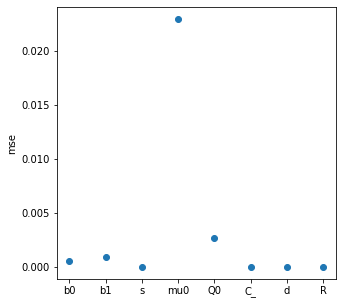

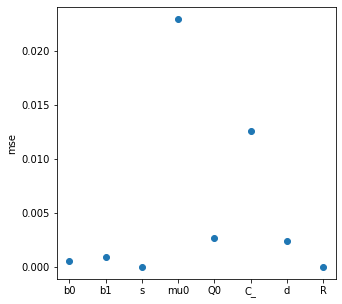

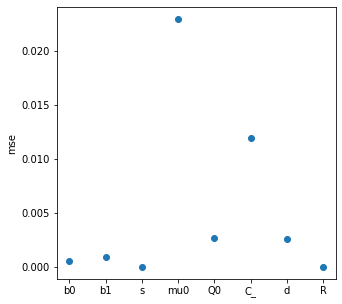

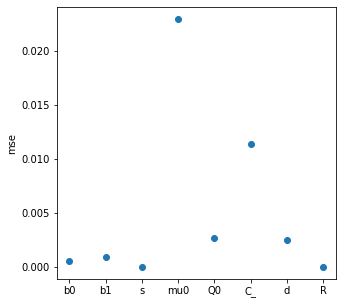

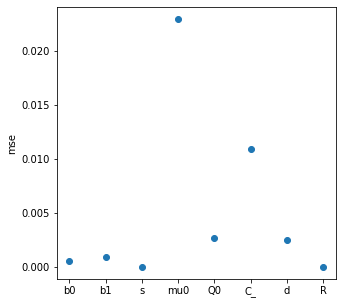

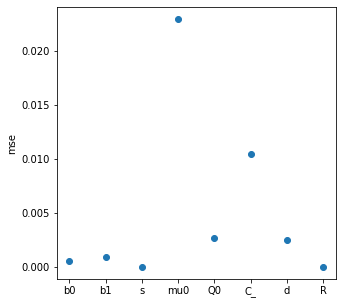

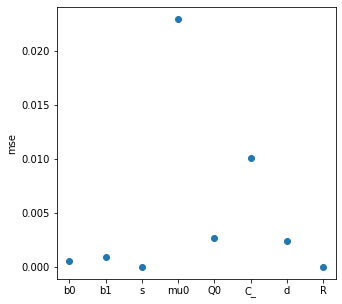

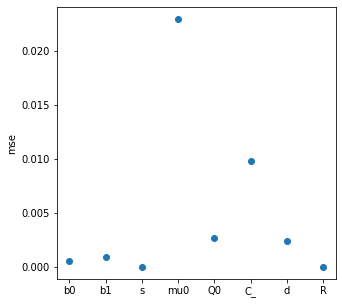

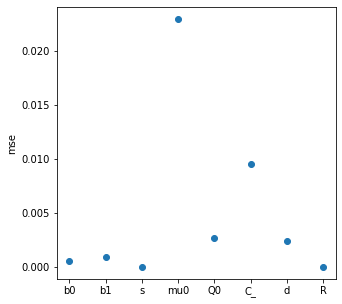

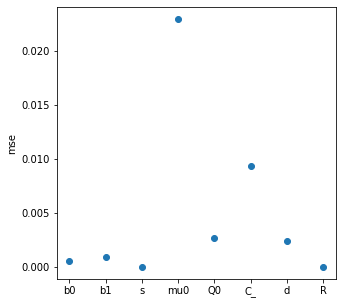

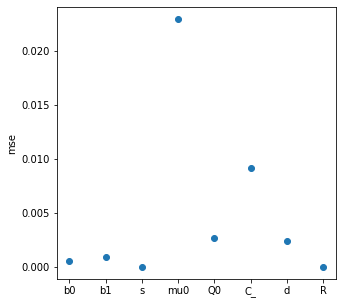

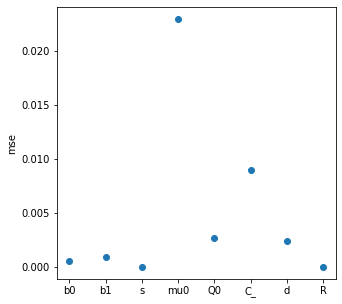

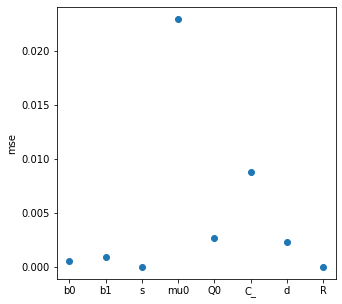

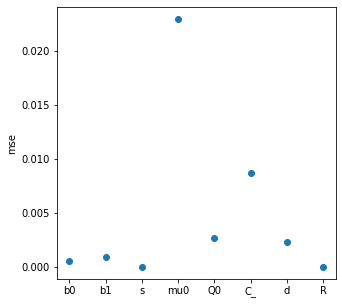

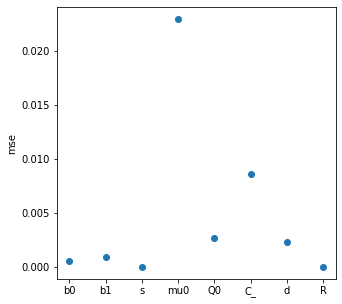

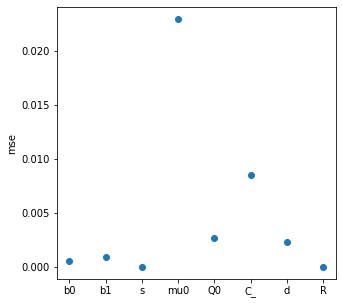

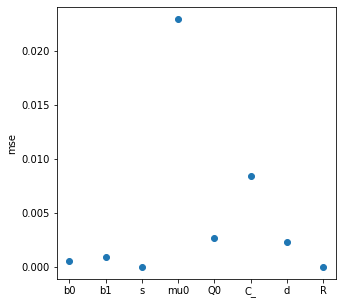

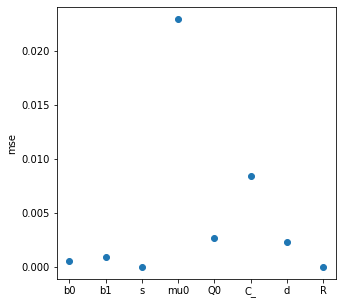

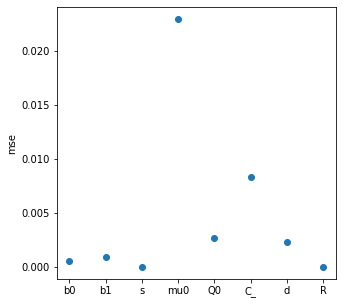

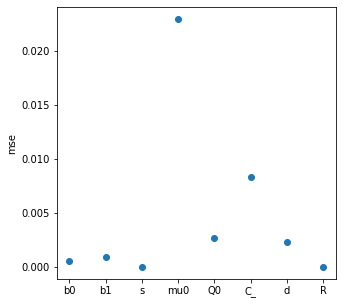

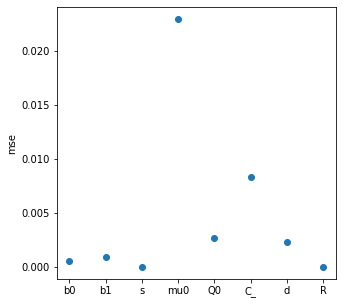

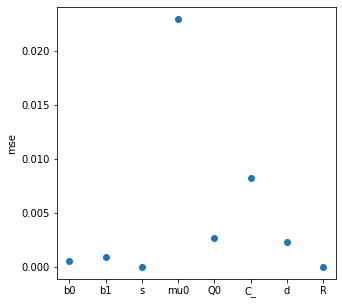

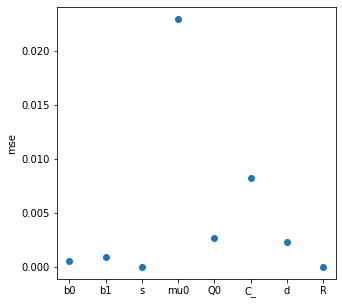

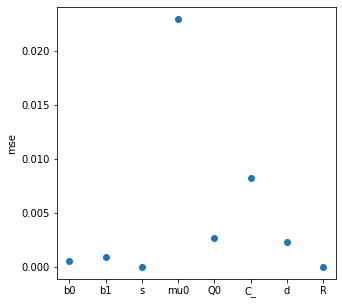

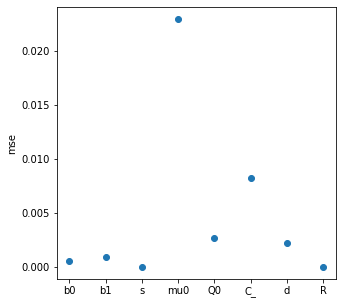

In [18]:
for iter in range(max_iter):
    fig, axes = plt.subplots(figsize=(5,5))
    plot_mse_parameters(axes, b, s, mu0, Q0, C_all[iter], d_all[iter], np.zeros((2,2)), true_b.item(), true_s, true_mu0, true_Q0, true_C_, true_d, np.zeros((2,2)))
    plt.show()

In [ ]:
# compute loss and ecll and ll after last iteration

w = RNN.get_nonzero_weight_vector(fitW)
m = np.zeros((U, T, RNN.K, 1))
cov = np.zeros((U, T, RNN.K, RNN.K))
cov_next = np.zeros((U, T-1, RNN.K, RNN.K))

ll1 = np.zeros((U))
for u in range(U): # iterate across all trials
    # E-step
    mu, mu_prior, V, V_prior, ll1[u] = RNN.Kalman_filter_E_step(true_y[u], w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, R)
    m[u], cov[u], cov_next[u] = RNN.Kalman_smoother_E_step(fitA, mu, mu_prior, V, V_prior)
ecll1, _ = RNN.compute_ELBO(true_y, w, b, s, mu0, Q0, C_, d, R, m, cov, cov_next)

print(ll1)
print(ecll1)

ll2 = np.zeros((U))
for u in range(U): # iterate across all trials
    # E-step
    mu, mu_prior, V, V_prior, ll1[u] = RNN.Kalman_filter_E_step(true_y[u], w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R)
    m[u], cov[u], cov_next[u] = RNN.Kalman_smoother_E_step(fitA, mu, mu_prior, V, V_prior)
ecll2, _ = RNN.compute_ELBO(true_y, w, b, s, mu0, Q0, C_, d, R, m, cov, cov_next)

print(ll2)
print(ecll2)
           

In [164]:
# generate network activity from fit W
v = data['v']

fitW = RNN.build_full_weight_matrix(w)
unstable, n_unstable = check_unstable(fitW)

if unstable == False: # stable 
    v = RNN.generate_network_activity(U, T, fitW, b.item(), s, mu0, Q0)
        # print('generated network activity')
else:
    v = np.zeros((1))

print(v)

[[[[-0.02189967]
   [ 0.05307317]
   [ 0.00398781]
   ...
   [-0.00320222]
   [-0.0261513 ]
   [ 0.0372771 ]]

  [[ 1.46477289]
   [-0.03923508]
   [ 0.42063474]
   ...
   [ 0.84002446]
   [-0.80140247]
   [ 0.17783776]]

  [[-0.9641546 ]
   [-0.87780754]
   [ 0.30167643]
   ...
   [ 0.87427945]
   [ 1.56536485]
   [-1.95719807]]

  ...

  [[-0.44726641]
   [ 0.6927344 ]
   [-0.23475917]
   ...
   [-1.13379467]
   [-1.60496807]
   [ 1.24529922]]

  [[-1.50592191]
   [ 0.53131351]
   [-0.92484295]
   ...
   [ 0.14691945]
   [ 0.47996651]
   [ 0.62786539]]

  [[-1.84182816]
   [ 1.07868754]
   [ 0.27131807]
   ...
   [-0.23907803]
   [-0.31400941]
   [-0.58037242]]]


 [[[ 0.13442227]
   [ 0.04524266]
   [ 0.03868969]
   ...
   [ 0.08787721]
   [-0.02427361]
   [-0.14030665]]

  [[ 0.41036409]
   [ 0.25258607]
   [-1.35341646]
   ...
   [ 0.28849144]
   [ 0.12312067]
   [-1.07375913]]

  [[ 0.45924473]
   [ 2.23214728]
   [ 1.7884036 ]
   ...
   [-0.47916169]
   [ 1.31475256]
   [ 0.3349

Text(0, 0.5, 'network activity')

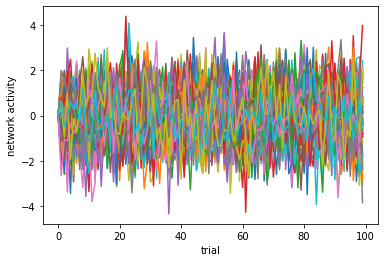

In [166]:
fig, axes = plt.subplots()
for i in range(T):
    axes.plot(v[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('network activity')

Text(0.5, 1.0, 'projected network activity on J')

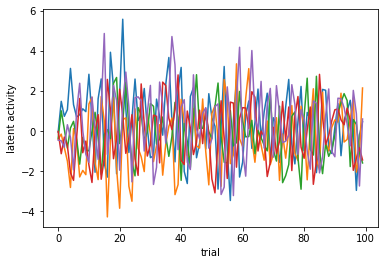

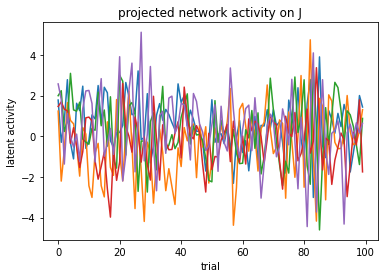

In [140]:
x, y = RNN.generate_latents_and_observations(U, T, trueA, true_b.item(), true_s, true_mu0, true_Q0, true_C_, true_d, true_R)

fig, axes = plt.subplots()
for i in range(K):
    axes.plot(x[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('latent activity')

fig, axes = plt.subplots()
for i in range(K):
    axes.plot((J @ v[0])[:,i])
axes.set_xlabel('trial')
axes.set_ylabel('latent activity')
axes.set_title('projected network activity on J')

Text(0, 0.5, 'neural activity')

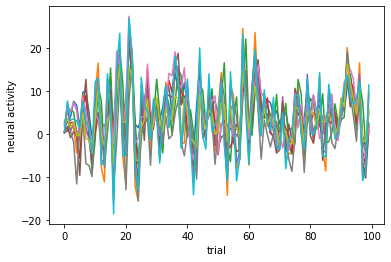

In [141]:
fig, axes = plt.subplots()
for i in range(10):
    axes.plot(y[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('neural activity')

(0.0, 0.5)

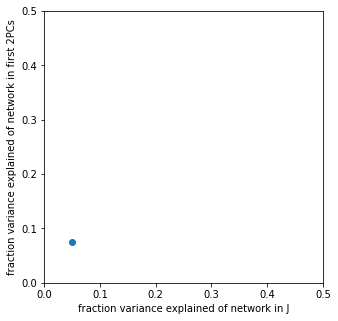

In [167]:
# alignment of two subspaces - variance explained in projection (for stable weights)

 
# PCA on data
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]

dim_PCA = K
fraction_cov_var_J, fraction_cov_var_PCA = covariance_alignment(v_concat, J, eigvec_PCA[:,:dim_PCA])

fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(fraction_cov_var_J,fraction_cov_var_PCA)
axes.set_xlabel('fraction variance explained of network in J')
axes.set_ylabel('fraction variance explained of network in first 2PCs')
axes.set_xlim(0,0.5)
axes.set_ylim(0,0.5)


Text(0.5, 1.0, 'PCA on data')

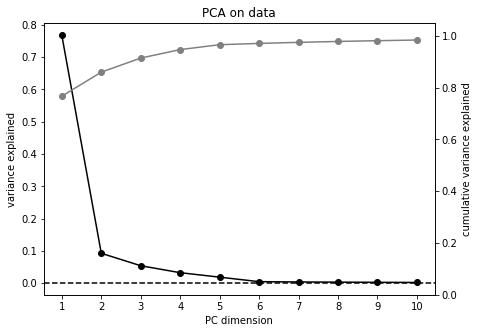

In [144]:
# PCA on data
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = y_concat.mean(axis=0)

# mean-center
y_concat = y_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(y_concat.T @ y_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((y_concat.shape[1]))
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]

# variance explained in PCA
fig, axes = plt.subplots(figsize=(7,5))
var_explained_pc = np.zeros((y_concat.shape[1]))
cumul_var_explained_pc = np.zeros((y_concat.shape[1]))
axes2 = axes.twinx()
for i in range(var_explained_pc.shape[0]):
    var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
    cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
axes.plot(range(10), var_explained_pc[:10], color='black')
axes.scatter(range(10), var_explained_pc[:10], label='individual', color='black')
axes2.plot(range(10), cumul_var_explained_pc[:10], color='gray')
axes2.scatter(range(10), cumul_var_explained_pc[:10], label='cumulative', color='gray')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_ylabel('variance explained')
axes2.set_ylabel('cumulative variance explained')
axes.set_xlabel('PC dimension')
axes.set_xticks(range(10),range(1,11))
axes2.set_ylim(0,1.05)
axes.set_title('PCA on data')

ValueError: x and y must have same first dimension, but have shapes (2,) and (5,)

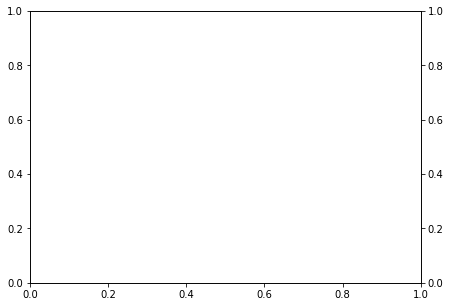

In [145]:
# PCA on data
x_concat = x.reshape(x.shape[0] * x.shape[1], x.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = x_concat.mean(axis=0)

# mean-center
x_concat = x_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(x_concat.T @ x_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((x_concat.shape[1]))
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]

# variance explained in PCA
fig, axes = plt.subplots(figsize=(7,5))
var_explained_pc = np.zeros((x_concat.shape[1]))
cumul_var_explained_pc = np.zeros((x_concat.shape[1]))
axes2 = axes.twinx()
for i in range(var_explained_pc.shape[0]):
    var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
    cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
axes.plot(range(2), var_explained_pc[:], color='black')
axes.scatter(range(2), var_explained_pc[:], label='individual', color='black')
axes2.plot(range(2), cumul_var_explained_pc[:], color='gray')
axes2.scatter(range(2), cumul_var_explained_pc[:], label='cumulative', color='gray')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_ylabel('variance explained')
axes2.set_ylabel('cumulative variance explained')
axes.set_xlabel('PC dimension')
axes.set_xticks(range(3),range(1,4))
axes2.set_ylim(0,1.05)
axes.set_title('PCA on latents')

Text(0.5, 1.0, 'PCA on network activity')

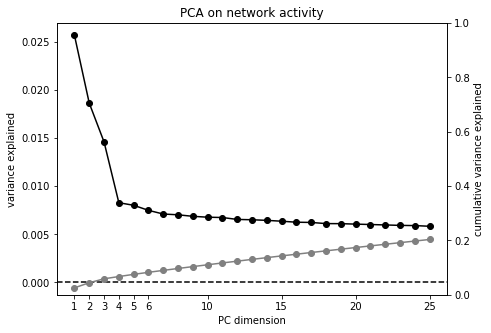

In [150]:
# PCA on network activity
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))

# variance explained in PCA
fig, axes = plt.subplots(figsize=(7,5))
var_explained_pc = np.zeros((v_concat.shape[1]))
cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
axes2 = axes.twinx()
for i in range(var_explained_pc.shape[0]):
    var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
    cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
axes.plot(range(25), var_explained_pc[:25], color='black')
axes.scatter(range(25), var_explained_pc[:25], label='individual', color='black')
axes2.plot(range(25), cumul_var_explained_pc[:25], color='gray')
axes2.scatter(range(25), cumul_var_explained_pc[:25], label='cumulative', color='gray')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_ylabel('variance explained')
axes2.set_ylabel('cumulative variance explained')
axes.set_xlabel('PC dimension')
axes.set_xticks([0,1,2,3,4,5,9,14,19,24],[1,2,3,4,5,6,10,15,20,25])
axes2.set_ylim(0,1)
axes.set_title('PCA on network activity')


In [35]:
# project network activity on J space and do PCA

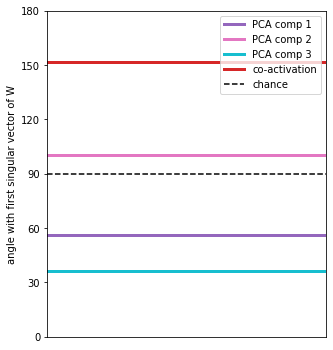

In [151]:
# SVD of fitted weight matrix - find dimension with high variance

U, s, Vh = np.linalg.svd(W)

fig, axes = plt.subplots(figsize=(5,6))
for k in range(3):
    axes.axhline(angle_vectors(U[:,0], eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)
axes.axhline(angle_vectors(U[:,0], ones), color='tab:red', label=f'co-activation', linewidth=3)
axes.axhline(90, color='black', linestyle='dashed', label='chance')
eps = 0.01
axes.set_xlim(0-eps, np.pi + eps)
axes.set_ylabel('angle with first singular vector of W')
axes.set_ylim(0,180)
axes.set_xlim(-1,1)
axes.set_xticks([],[])
axes.set_yticks([0,30,60,90,120,150,180],[0,30,60,90,120,150,180])
axes.legend()
plt.show()

In [37]:
pc1_proj_on_u1 = projection_on_vector(eigvec_PCA[:,0], U[:,0])

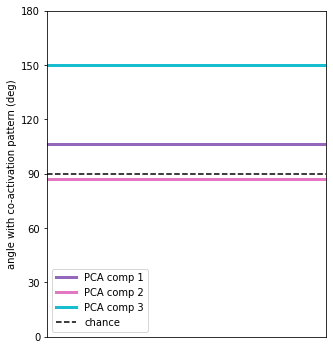

In [152]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(3):
    axes.axhline(angle_vectors(ones, eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)
axes.axhline(90, color='black', linestyle='dashed', label='chance')
eps = 0.01
axes.set_xlim(0-eps, np.pi + eps)
axes.set_ylabel('angle with co-activation pattern (deg)')
axes.set_ylim(0,180)
axes.set_xlim(-1,1)
axes.set_xticks([],[])
axes.set_yticks([0,30,60,90,120,150,180],[0,30,60,90,120,150,180])
axes.legend()
plt.show()

In [153]:
ones = np.ones((v_concat.shape[1]))
v_proj, angle = projection_on_subspace(ones,J)
print(angle)

79.32222720872204


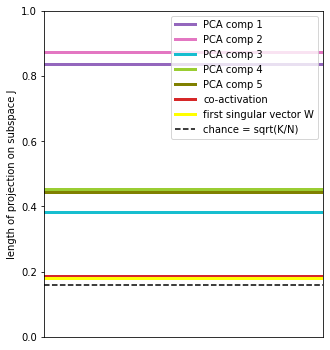

In [154]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
    axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

v_proj, angle = projection_on_subspace(ones, J)
axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)

v_proj, angle = projection_on_subspace(U[:,0],J)
axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color='yellow', label=f'first singular vector W', linewidth=3)


axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
axes.set_ylabel('length of projection on subspace J')
# axes.set_ylim(0,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()

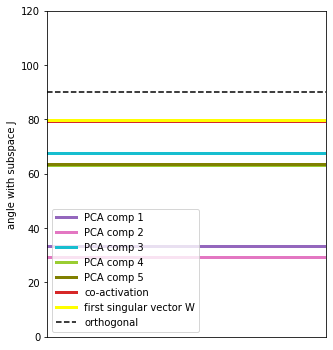

In [155]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
    axes.axhline(angle, color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

v_proj, angle = projection_on_subspace(ones,J)
axes.axhline(angle, color='tab:red', label=f'co-activation', linewidth=3)

v_proj, angle = projection_on_subspace(U[:,0],J)
axes.axhline(angle, color='yellow', label=f'first singular vector W', linewidth=3)

axes.axhline(90, color='black', linestyle='dashed', label='orthogonal')
axes.set_ylabel('angle with subspace J')
axes.set_ylim(0,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()

[[ 0.        -0.70710678j  0.        +0.70710678j]
 [-0.70710678+0.j         -0.70710678-0.j        ]]


IndexError: index 2 is out of bounds for axis 1 with size 2

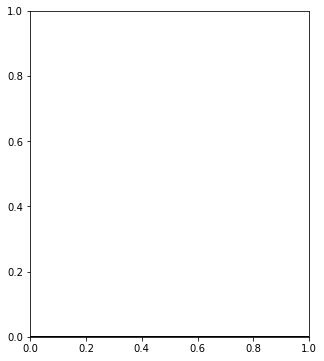

In [42]:
fig, axes = plt.subplots(figsize=(5,6))

def a(v1, v2):
    """Calculates the angle between two complex vectors."""
    return np.angle(np.dot(np.conj(v1), v2))

# eigvec_PCA_orthogonal_J = np.copy(eigvec_PCA)
# for k in range(K):
#     eigvec_PCA_orthogonal_J[k] = eigvec_PCA[:,k] @ (np.eye(N) - np.linalg.pinv(J) @ J)

eigval, eigvec = np.linalg.eig(trueA)
print(eigvec)

axes.axhline(a(eigvec[:,0], eigvec[:,1]), color='black', linewidth=3)
axes.axhline(a(eigvec[:,0], eigvec[:,2]), color='black', linewidth=3)
axes.axhline(a(eigvec[:,1], eigvec[:,2]), color='black', linewidth=3)

axes.axhline(90, color='black', linestyle='dashed', label='orthogonal')
axes.set_ylabel('angles between eigenvectors of A')
axes.set_ylim(-5,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()